In [1]:
import shap
import random

import pandas as pd
import numpy as np

import dr_explainer as dre

import matplotlib.pyplot as plt

from sklearn.datasets import load_iris

In [2]:
data = load_iris()
X, y = data.data, data.target

### Project the dataset

In [3]:
import umap

reducer = umap.UMAP(verbose=0, random_state=0)
embedding = reducer.fit_transform(X)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


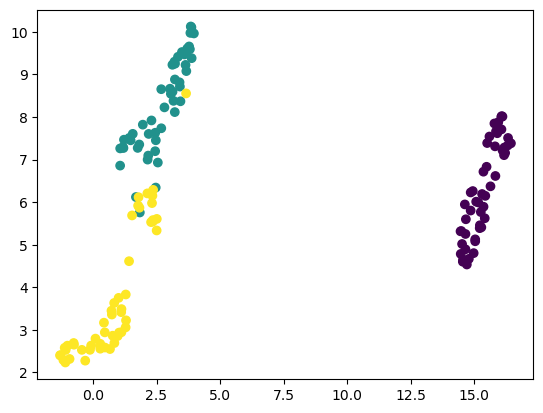

In [4]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=y)

### Generate explanations for the ground truth classes

In [5]:
clusterShapley = dre.ClusterShapley()
clusterShapley.fit(X, y)

Preprocessing data...
Creating summary of the background dataset...
Computing explanations...


### Compute explanations for a few samples

In [6]:
sample = random.sample(range(0, X.shape[0]), int(X.shape[0]*0.2))

to_explain = np.array(X)[sample]
clustering_labels = np.array(y)[sample]

shap_values = clusterShapley.transform(to_explain)

  0%|          | 0/30 [00:00<?, ?it/s]

In [7]:
shap_values.shape

(3, 30, 4)

##### The matrix shap_values contains: 
* the feature contributions for each cluster/class (3);
* upon the samples used to generate explanations (30);
* for each feature (4).

### Visualize the contributions using SHAP plots

For now, you can rely on SHAP library to visualize the contributions

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


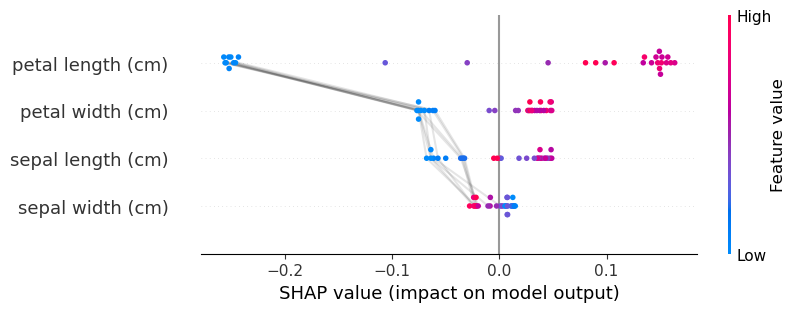

In [8]:
from dr_explainer import beeswarm

klass = 0
beeswarm(klass, shap_values, to_explain, clustering_labels, data.feature_names)

### How to interpret?

The plot shows the contributions of each feature for cluster/class cohesion for the selected cluster/class.

Example for 'petal length (cm)':

* Low feature values (blue) contribute for the cohesion of the selected class/cluster.
* Higher feature values (red) **do not** contribute for the cohesion.

### Defining your own clusters

Suppose you want to investigate why UMAP cluster 2 classes together while projecting the third one distant in 2D.

To investigate that, we can use ClusterShapley to explain how the features contribute to these **two** major clusters.

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(embedding)

indices = np.arange(embedding.shape[0])

indices_0 = indices[kmeans.labels_ == 0]
indices_1 = indices[kmeans.labels_ == 1]

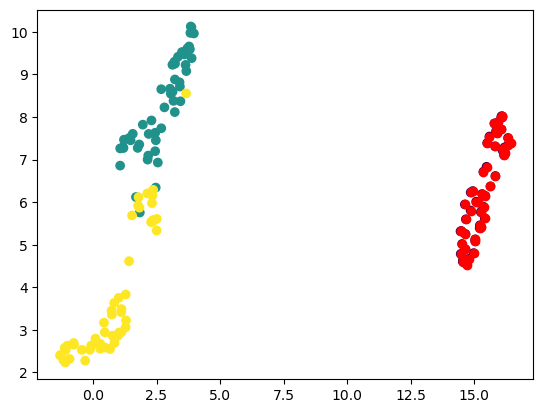

In [10]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=y)
plt.scatter(embedding[indices_0, 0], embedding[indices_0, 1], c='red')

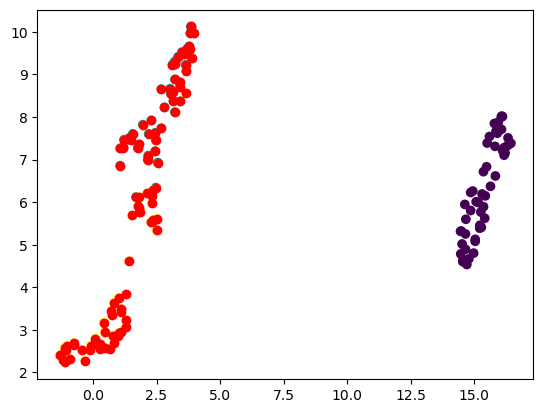

In [11]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=y)
plt.scatter(embedding[indices_1, 0], embedding[indices_1, 1], c='red')

So, 

* we have **cluster 0** as the cluster on **right**;
* we have **cluster 1** as the cluster on **left**.

Lets generate explanations for these two clusters **upon** UMAP projection.

In [12]:
clusterShapley = dre.ClusterShapley()
clusterShapley.fit(X, kmeans.labels_)

Preprocessing data...
Creating summary of the background dataset...
Computing explanations...


In [13]:
shap_values = clusterShapley.transform(to_explain)

  0%|          | 0/30 [00:00<?, ?it/s]

### Right cluster 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


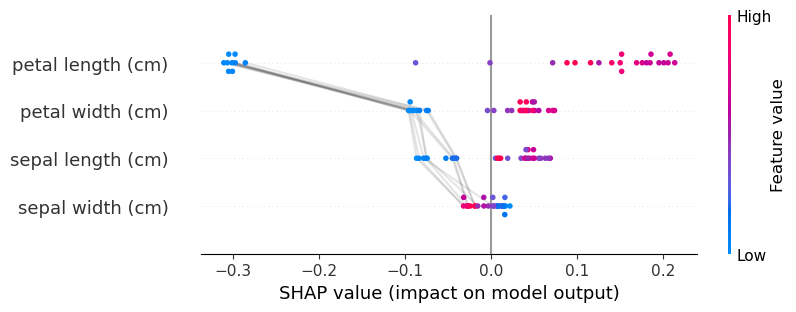

In [16]:
klass = 0
beeswarm(klass, shap_values, to_explain, kmeans.labels_[sample], data.feature_names)

This cluster is characterized by the low values of *petal length (cm)*, *petal width (cm)*, *sepal length (cm)*.

### Left cluster

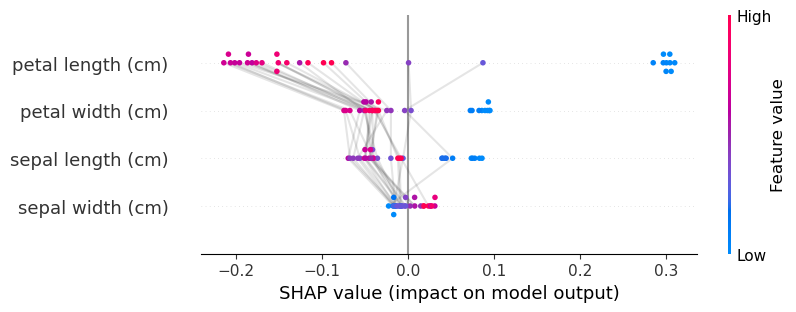

In [17]:
klass = 1
beeswarm(klass, shap_values, to_explain, kmeans.labels_[sample], data.feature_names)

On the other hand, the left cluster (composed by two classes) is characterized by high values of *petal length (cm)*, *petal width (cm)*, *sepal length (cm)*.